In [1]:
import torch
from torch.utils.data import DataLoader
import voc12.dataloader
from misc import pyutils, torchutils, indexing, imutils
import importlib
from tqdm import tqdm
import cv2
import numpy as np
import os
from utility import image_util, util
import torch.nn.functional as F


In [2]:
infer_list = "voc12/val.txt"
voc12_root ="../Dataset/VOC2012/"
depth_root = "../result/depth_img/"
cam_root = "../irn_result/cam"

beta = 5
exp_times = 10

device = 'cuda:0'

In [3]:
dataset = voc12.dataloader.VOC12ClassificationDatasetMSF(infer_list,
                                                             voc12_root=voc12_root,
                                                             scales=(1.0,))

In [20]:
idx = 25
pack = dataset[idx]

with torch.no_grad():
    name = pack['name']
    org_img_size = pack['size']
    print(org_img_size)
    
    strided_size = imutils.get_strided_size(org_img_size, 4)
    
    depth_map = image_util.read_image(os.path.join(depth_root, name+'.png'))
    
    edge_map = util.depth_to_edge(depth_map)
    edge_map = util.normalize(edge_map)
    edge_map = torch.from_numpy(edge_map).unsqueeze(0).to(device)

    edge_map = F.interpolate(torch.unsqueeze(edge_map, 0), strided_size, mode='bilinear', align_corners=False)
    
    cam_dict = np.load(os.path.join(cam_root, name + '.npy'), allow_pickle=True).item()
    
    cams = cam_dict['cam']
    keys = np.pad(cam_dict['keys'] + 1, (1,0), mode='constant')
    
    cam_downsized_values = cams.to(device)
    
    rw = indexing.propagate_to_edge(cam_downsized_values, edge_map, beta=beta, exp_times=exp_times, device=device)




(500, 375)


In [21]:
print(rw)

tensor([[[[0.0444, 0.0444, 0.0443,  ..., 0.0403, 0.0403, 0.0403],
          [0.0444, 0.0444, 0.0444,  ..., 0.0403, 0.0403, 0.0403],
          [0.0444, 0.0444, 0.0444,  ..., 0.0403, 0.0403, 0.0403],
          ...,
          [0.0620, 0.0620, 0.0620,  ..., 0.0552, 0.0552, 0.0552],
          [0.0620, 0.0620, 0.0620,  ..., 0.0552, 0.0552, 0.0552],
          [0.0620, 0.0620, 0.0620,  ..., 0.0552, 0.0552, 0.0552]]]],
       device='cuda:0', dtype=torch.float64)


In [22]:
rw_up = F.interpolate(rw, scale_factor=4, mode='bilinear', align_corners=False)[..., 0, :org_img_size[0], :org_img_size[1]]
rw_up = rw_up / torch.max(rw_up)

rw_up_bg = F.pad(rw_up, (0, 0, 0, 0, 1, 0), value=0.25)
# rw_up_bg = F.pad(rw_up, (0, 0, 0, 0, 1, 0), value=0)
rw_pred = torch.argmax(rw_up_bg, dim=0).cpu().numpy()

rw_pred = keys[rw_pred]

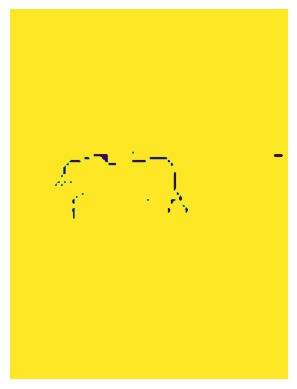

In [23]:
image_util.image_show(rw_pred)

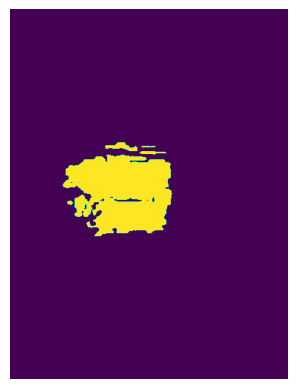

In [24]:
seg_root = "../irn_result/sem_seg/"

image_util.image_show(os.path.join(seg_root, name+".png"))